In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

path = os.getcwd()
file_path = os.path.join(path,"file")
sub_path = os.path.join(path,"제출")
sub_num = 36
train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))
weights_path = os.path.join(path,"save_weights")
if not os.path.isdir(weights_path):
    os.mkdir(weights_path)

In [2]:
from pytimekr import pytimekr
import datetime

List_holiday = []
for i in range(5,1523,7):
    List_holiday.append((datetime.datetime(2019, 1, 1)+datetime.timedelta(i)).strftime("%Y-%m-%d"))
    
for i in range(2019,2024):
    List_holiday.extend(pytimekr.holidays(year=i)) #리스트 형태로 반환

for i in range(len(List_holiday)):
    List_holiday[i] = str(List_holiday[i])
np.sort(List_holiday)

array(['2019-01-01', '2019-01-06', '2019-01-13', '2019-01-20',
       '2019-01-27', '2019-02-03', '2019-02-04', '2019-02-05',
       '2019-02-06', '2019-02-10', '2019-02-17', '2019-02-24',
       '2019-03-01', '2019-03-03', '2019-03-10', '2019-03-17',
       '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
       '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-05',
       '2019-05-12', '2019-05-12', '2019-05-19', '2019-05-26',
       '2019-06-02', '2019-06-06', '2019-06-09', '2019-06-16',
       '2019-06-23', '2019-06-30', '2019-07-07', '2019-07-14',
       '2019-07-21', '2019-07-28', '2019-08-04', '2019-08-11',
       '2019-08-15', '2019-08-18', '2019-08-25', '2019-09-01',
       '2019-09-08', '2019-09-12', '2019-09-13', '2019-09-14',
       '2019-09-15', '2019-09-22', '2019-09-29', '2019-10-03',
       '2019-10-06', '2019-10-09', '2019-10-13', '2019-10-20',
       '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
       '2019-11-24', '2019-12-01', '2019-12-08', '2019-

In [3]:
Holiday_y_n = []
for i in range(0,1523):
    if (datetime.datetime(2019, 1, 1)+datetime.timedelta(i)).strftime("%Y-%m-%d") in List_holiday:
        Holiday_y_n.append(0)
    else:
        Holiday_y_n.append(1)

In [4]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

In [5]:
a = test_df['ID'].str.split("_")
I = ""
J = ""
K = ""
List_Test = []
for i,j,k,l in a:
    if I!=i or J!=j or K!=k:
        List_Test.append([i,j,k])
        I = i
        J = j
        K = k
    else:
        continue

In [6]:
List_i_c_l = []
for i in train_df['item'].unique():
    for j in train_df['corporation'].unique():
        for k in train_df['location'].unique():
            if train_df.loc[(train_df['item']==i) & (train_df['corporation']==j) & (train_df['location']==k) ,:].shape[0]!=0:
                List_i_c_l.append([i,j,k])

In [7]:
List_i_c_l

[['TG', 'A', 'J'],
 ['TG', 'A', 'S'],
 ['TG', 'B', 'J'],
 ['TG', 'B', 'S'],
 ['TG', 'C', 'J'],
 ['TG', 'C', 'S'],
 ['TG', 'D', 'J'],
 ['TG', 'D', 'S'],
 ['TG', 'E', 'J'],
 ['TG', 'E', 'S'],
 ['CR', 'A', 'J'],
 ['CR', 'B', 'J'],
 ['CR', 'C', 'J'],
 ['CR', 'D', 'J'],
 ['CR', 'D', 'S'],
 ['CR', 'E', 'J'],
 ['CR', 'E', 'S'],
 ['CB', 'A', 'J'],
 ['CB', 'A', 'S'],
 ['CB', 'D', 'J'],
 ['CB', 'E', 'J'],
 ['CB', 'F', 'J'],
 ['RD', 'A', 'J'],
 ['RD', 'A', 'S'],
 ['RD', 'C', 'S'],
 ['RD', 'D', 'J'],
 ['RD', 'D', 'S'],
 ['RD', 'E', 'J'],
 ['RD', 'E', 'S'],
 ['RD', 'F', 'J'],
 ['BC', 'A', 'J'],
 ['BC', 'A', 'S'],
 ['BC', 'B', 'J'],
 ['BC', 'B', 'S'],
 ['BC', 'C', 'J'],
 ['BC', 'C', 'S'],
 ['BC', 'D', 'J'],
 ['BC', 'E', 'J'],
 ['BC', 'E', 'S']]

In [8]:
for i, j, k in List_i_c_l:
    globals()[f"train_{i}_{j}_{k}"]=train_df.loc[(train_df['item']==i) & (train_df['corporation']==j) & (train_df['location']==k) ,:]
    globals()[f"train_{i}_{j}_{k}"].drop(columns=['ID', 'timestamp', 'corporation','location'])
    globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
    globals()[f"train_{i}_{j}_{k}"] = globals()[f"train_{i}_{j}_{k}"][['supply(kg)', 'year', 'month', 'day','Holiday', 'price(원/kg)']]
    globals()[f"train_ar_{i}_{j}_{k}"] = np.array(globals()[f"train_{i}_{j}_{k}"])
#     print(i,j,k,globals()[f"train_{i}_{j}_{k}"].shape)
#     display(globals()[f"train_{i}_{j}_{k}"].corr())

C:\Users\USER\AppData\Local\Temp\ipykernel_7400\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
C:\Users\USER\AppData\Local\Temp\ipykernel_7400\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  globals()[f"train_{i}_{j}_{k}"]['Holiday'] = Holiday_y_n
C:\Users\USER\AppData\Local\Temp\ipykernel_7400\2872114995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [9]:
def minmaxscaler(data):
    s_data = (data-np.min(data,axis=0))/(np.max(data,axis=0)-np.min(data,axis=0))
    return s_data, np.min(data,axis=0), np.max(data,axis=0)

In [10]:
num = {"TG":10,"CR":7,"CB":5,"RD":8,"BC":9}
shape = globals()[f"train_ar_{i}_{j}_{k}"].shape
for i in train_df['item'].unique():
    globals()[f"train_x_concat_{i}"] = np.zeros((shape[0],num[i],shape[1]))
name = List_i_c_l[0][0]
n = 0
for i, j, k in List_i_c_l:
    if name != i :
        name=i
        n=0
    globals()[f"train_x_concat_{i}"][:,n,:] = globals()[f"train_ar_{i}_{j}_{k}"]
    n+=1
    globals()[f"train_minmax_{i}"],globals()[f"train_min_{i}"],globals()[f"train_max_{i}"] = minmaxscaler(globals()[f"train_x_concat_{i}"])

C:\Users\USER\AppData\Local\Temp\ipykernel_7400\313065710.py:2: RuntimeWarning: invalid value encountered in divide
  s_data = (data-np.min(data,axis=0))/(np.max(data,axis=0)-np.min(data,axis=0))


In [11]:
def build_dataset(Training_data, seq_length, future_length):
    dataX = []
    dataY = []
    for i in range(0, Training_data.shape[0]-seq_length-future_length+1): 
        _x = Training_data[i:i+seq_length,:,:]
        _y = Training_data[i+seq_length:i+seq_length+future_length,:,-1] 
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [12]:
print(globals()[f"train_minmax_{i}"].shape)

(1523, 9, 6)


In [13]:
S_Length = 28
pred_Length = 28

for i in train_df['item'].unique():
    globals()[f"Train_x_{i}"], globals()[f"train_y_{i}"] = build_dataset(globals()[f"train_minmax_{i}"], S_Length, pred_Length)
    globals()[f"train_x_{i}"] = np.reshape(globals()[f"Train_x_{i}"],(globals()[f"Train_x_{i}"].shape[0],globals()[f"Train_x_{i}"].shape[1],-1))
    print(globals()[f"train_x_{i}"].shape, globals()[f"train_y_{i}"].shape)

(1468, 28, 60) (1468, 28, 10)
(1468, 28, 42) (1468, 28, 7)
(1468, 28, 30) (1468, 28, 5)
(1468, 28, 48) (1468, 28, 8)
(1468, 28, 54) (1468, 28, 9)


In [14]:
def rmse(y_true,y_pred):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.pow((y_true-y_pred),2)))

In [15]:
import tensorflow.keras.backend as K
def my_relu(x):
    return K.maximum(0.0, x)
def my_leaky_relu(x):
    alpha = 0.01
    return K.maximum(alpha*x, x)
def my_elu(x):
    # ELU 함수
    # alpha 값이 1외에 다른 값이면 SeLU가 된다.
    alpha = 1 
    return K.maximum(0., x) + K.maximum(0., -x) * (-1./(x+0.000001)) * alpha * (K.exp(x)-1)

for i in train_df['item'].unique():
    #TG : 0.0005
    # CR : 0.0001
    # 나머지 : 0.001
    globals()[f"Model{i}"]=tf.keras.Sequential()
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=10, return_sequences = True, input_shape=(S_Length,globals()[f"train_x_{i}"].shape[2])))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.LSTM(units=15,return_sequences = True))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_elu))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(lambda x: x[:, -28:, :]))
    globals()[f"Model{i}"].add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(globals()[f"train_y_{i}"].shape[2])))
    globals()[f"Model{i}"].add(tf.keras.layers.Lambda(my_relu))
    globals()[f"Model{i}"].compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.0001))
    globals()[f"Model{i}"].summary()
    globals()[f"Model{i}"].fit(globals()[f"train_x_{i}"], globals()[f"train_y_{i}"], epochs=5000,batch_size = 32)
    globals()[f"Model{i}"].save_weights(os.path.join(weights_path, i+"_weights"+str(sub_num)))

C:\Users\USER\anaconda3\envs\SU\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 10)            2840      
_________________________________________________________________
lambda (Lambda)              (None, 28, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 28, 15)            1560      
_________________________________________________________________
lambda_1 (Lambda)            (None, 28, 15)            0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 28, 15)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 10)            160       
_________________________________________________________________
lambda_3 (Lambda)            (None, 28, 10)            0

46/46 [==============================] - 0s 3ms/step - loss: 0.0334
Epoch 86/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0334
Epoch 87/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0334
Epoch 88/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0333
Epoch 89/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0333
Epoch 90/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0333
Epoch 91/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0332
Epoch 92/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0332
Epoch 93/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0332
Epoch 94/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0331
Epoch 95/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0331
Epoch 96/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0331
Epoch 97/5000
46/46 [=========

46/46 [==============================] - 0s 3ms/step - loss: 0.0221
Epoch 185/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0221
Epoch 186/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0221
Epoch 187/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 188/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 189/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 190/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0220
Epoch 191/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 192/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 193/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 194/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 195/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 196/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 283/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 284/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 285/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 286/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 287/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 288/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 289/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 290/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 291/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 292/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 293/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 294/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 381/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 382/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 383/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 384/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 385/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 386/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 387/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 388/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 389/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 390/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 391/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 392/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 479/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 480/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 481/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 482/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 483/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 484/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 485/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 486/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 487/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 488/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 489/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 490/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 577/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 578/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 579/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 580/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 581/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 582/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 583/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 584/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 585/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 586/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 587/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 588/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 675/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 676/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 677/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 678/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 679/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 680/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 681/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 682/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 683/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 684/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 685/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 686/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 773/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 774/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 775/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 776/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 777/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 778/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 779/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 780/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 781/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 782/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 783/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 784/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 871/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 872/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 873/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 874/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 875/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 876/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 877/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 878/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 879/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 880/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 881/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 882/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 969/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 970/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 971/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 972/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 973/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 974/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 975/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 976/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 977/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 978/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 979/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 980/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1067/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1068/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1069/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1070/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1071/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1072/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1073/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1074/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1075/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1076/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1077/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 10

46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1164/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1165/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1166/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1167/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1168/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1169/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1170/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1171/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1172/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 1173/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1174/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 11

46/46 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1261/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1262/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1263/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 1264/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 1265/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 1266/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 1267/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 1268/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 1269/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 1270/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 1271/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 12

46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1358/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1359/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1360/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1361/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1362/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1363/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1364/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1365/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1366/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1367/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 1368/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 13

46/46 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 1455/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 1456/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 1457/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 1458/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1459/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1460/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1461/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1462/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1463/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 1464/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 1465/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 14

46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1552/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1553/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1554/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1555/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1556/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1557/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1558/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1559/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 1560/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 1561/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 1562/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 15

46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1649/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1650/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1651/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1652/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1653/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1654/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1655/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1656/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1657/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1658/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 1659/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 16

46/46 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 1746/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 1747/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 1748/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 1749/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 1750/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 1751/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 1752/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 1753/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 1754/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 1755/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 1756/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 17

46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1843/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1844/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1845/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1846/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1847/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1848/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1849/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1850/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1851/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1852/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 1853/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 18

46/46 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 1940/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1941/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1942/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1943/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1944/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1945/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1946/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1947/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1948/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1949/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 1950/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 19

46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 2037/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 2038/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 2039/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 2040/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 2041/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 2042/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 2043/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 2044/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 2045/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 2046/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 2047/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 20

46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2134/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2135/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2136/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2137/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2138/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2139/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2140/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2141/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2142/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2143/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2144/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 21

46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2231/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2232/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2233/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2234/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2235/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2236/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2237/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2238/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2239/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2240/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2241/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 22

46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2328/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2329/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2330/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2331/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2332/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2333/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2334/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2335/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 2336/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 2337/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 2338/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 23

46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2425/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 2426/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2427/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2428/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2429/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2430/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2431/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2432/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2433/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2434/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2435/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 24

46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2522/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2523/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2524/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2525/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2526/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2527/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2528/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2529/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2530/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2531/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2532/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 25

46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2619/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2620/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2621/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2622/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2623/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2624/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2625/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2626/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2627/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2628/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2629/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 26

46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2716/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2717/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2718/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2719/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2720/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2721/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2722/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2723/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2724/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2725/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2726/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 27

46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2813/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2814/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2815/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2816/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2817/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2818/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2819/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2820/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2821/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2822/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 2823/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 28

46/46 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 2910/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 2911/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 2912/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 2913/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 2914/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 2915/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 2916/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 2917/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 2918/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 2919/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 2920/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 29

46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3007/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3008/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3009/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3010/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3011/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3012/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3013/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3014/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3015/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3016/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3017/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 30

46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3104/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3105/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3106/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3107/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3108/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3109/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3110/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3111/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3112/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3113/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3114/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 31

46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3201/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3202/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3203/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3204/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3205/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3206/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3207/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3208/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3209/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3210/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3211/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 32

46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3298/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3299/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3300/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3301/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3302/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3303/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3304/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3305/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 3306/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3307/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3308/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 33

46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3395/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3396/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3397/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3398/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3399/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3400/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3401/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3402/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3403/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3404/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3405/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 34

46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3492/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3493/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3494/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3495/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3496/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3497/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3498/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3499/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3500/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3501/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3502/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 35

46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3589/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3590/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 3591/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 3592/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3593/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3594/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3595/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3596/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3597/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3598/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3599/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 36

46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3686/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3687/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3688/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3689/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3690/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3691/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3692/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3693/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3694/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3695/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3696/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 36

46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3783/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3784/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3785/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3786/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3787/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3788/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 3789/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 3790/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 3791/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 3792/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 3793/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 37

46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3880/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3881/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3882/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3883/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3884/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3885/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3886/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 3887/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3888/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3889/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 3890/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 38

46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3977/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3978/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3979/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3980/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3981/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3982/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3983/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3984/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3985/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3986/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 3987/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 39

46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4074/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4075/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4076/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4077/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4078/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4079/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4080/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4081/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4082/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4083/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4084/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 40

46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4171/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4172/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4173/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4174/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4175/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4176/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4177/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4178/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4179/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4180/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4181/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 41

46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 4268/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 4269/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 4270/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 4271/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 4272/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4273/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4274/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4275/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4276/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4277/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4278/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 42

46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4365/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4366/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4367/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4368/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4369/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4370/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4371/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4372/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4373/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4374/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4375/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 43

46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4462/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4463/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4464/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4465/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4466/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4467/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4468/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4469/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4470/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4471/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4472/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 44

46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4559/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4560/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4561/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4562/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4563/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4564/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4565/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4566/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4567/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4568/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4569/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 45

46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4656/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4657/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4658/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4659/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 4660/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4661/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4662/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4663/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4664/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4665/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4666/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 46

46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4753/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4754/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4755/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4756/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4757/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4758/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4759/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4760/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4761/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4762/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4763/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 47

46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4850/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4851/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4852/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4853/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4854/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4855/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4856/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4857/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4858/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4859/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4860/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 48

46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4947/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4948/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4949/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4950/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4951/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4952/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4953/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4954/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4955/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4956/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4957/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 49

46/46 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 30/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0241
Epoch 31/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0240
Epoch 32/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0240
Epoch 33/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0239
Epoch 34/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 35/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 36/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 37/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 38/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 39/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0235
Epoch 40/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0234
Epoch 41/5000
46/46 [=========

46/46 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 129/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 130/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 131/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 132/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 133/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 134/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0173
Epoch 135/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 136/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 137/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 138/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 139/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 140/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 227/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 228/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 229/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 230/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 231/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 232/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 233/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 234/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 235/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 236/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 237/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 238/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 325/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 326/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 327/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 328/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 329/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 330/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 331/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 332/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 333/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 334/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 335/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 336/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 423/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 424/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 425/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 426/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 427/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 428/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 429/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 430/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 431/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 432/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 433/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 434/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 521/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 522/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 523/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 524/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 525/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 526/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 527/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 528/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 529/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 530/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 531/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 532/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 619/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 620/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 621/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 622/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 623/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 624/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 625/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 626/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 627/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 628/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 629/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 630/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 717/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 718/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 719/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 720/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 721/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 722/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 723/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 724/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 725/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 726/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 727/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 728/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 815/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 816/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 817/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 818/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 819/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 820/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 821/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 822/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 823/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 824/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 825/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 826/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 913/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 914/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 915/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 916/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 917/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 918/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 919/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 920/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 921/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 922/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 923/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 924/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1011/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1012/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1013/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1014/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1015/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1016/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1017/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1018/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1019/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1020/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1021/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 10

46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1108/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1109/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1110/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1111/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1112/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1113/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1114/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1115/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1116/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1117/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1118/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 11

46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1205/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1206/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1207/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1208/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1209/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1210/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1211/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1212/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1213/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1214/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 1215/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 12

46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1302/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1303/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1304/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1305/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1306/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1307/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1308/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1309/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1310/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1311/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1312/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 13

46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1399/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1400/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1401/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1402/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1403/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1404/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1405/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1406/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1407/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1408/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1409/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 14

46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1496/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1497/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1498/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1499/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1500/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1501/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1502/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1503/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1504/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1505/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1506/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 15

46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1593/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1594/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1595/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1596/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 1597/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1598/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1599/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1600/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1601/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1602/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1603/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 16

46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1690/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1691/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1692/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1693/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1694/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1695/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1696/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1697/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1698/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1699/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 1700/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 17

46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1787/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1788/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1789/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1790/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1791/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1792/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1793/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1794/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 1795/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1796/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1797/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 17

46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1884/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1885/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1886/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1887/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1888/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1889/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1890/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1891/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1892/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1893/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1894/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 18

46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1981/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1982/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1983/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1984/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 1985/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1986/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1987/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1988/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1989/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1990/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 1991/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 19

46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2078/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2079/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2080/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2081/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2082/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2083/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2084/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2085/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2086/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2087/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2088/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 20

46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2175/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2176/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2177/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2178/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2179/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2180/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2181/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2182/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2183/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2184/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2185/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 21

46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2272/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2273/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2274/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2275/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2276/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2277/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2278/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2279/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2280/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2281/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2282/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 22

46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2369/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2370/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2371/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2372/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2373/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2374/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2375/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2376/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2377/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 2378/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2379/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 23

46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2466/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2467/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2468/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 2469/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2470/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2471/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2472/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2473/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2474/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2475/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2476/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 24

46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2563/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2564/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2565/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2566/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2567/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2568/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2569/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2570/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2571/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2572/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2573/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 25

46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2660/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2661/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2662/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2663/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2664/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2665/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2666/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2667/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2668/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2669/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2670/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 26

46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2757/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2758/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2759/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2760/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2761/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2762/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2763/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2764/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2765/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2766/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2767/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 27

46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2854/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2855/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 2856/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2857/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2858/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2859/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 2860/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2861/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2862/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2863/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2864/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 28

46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2951/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2952/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2953/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2954/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2955/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2956/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2957/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2958/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2959/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2960/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2961/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 29

46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3048/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3049/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3050/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3051/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3052/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3053/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3054/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3055/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 3056/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 3057/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 3058/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 30

46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3145/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3146/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3147/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3148/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3149/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3150/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3151/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3152/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3153/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3154/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3155/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 31

46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3242/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3243/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3244/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3245/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3246/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3247/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3248/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3249/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3250/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3251/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3252/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 32

46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3339/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3340/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3341/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3342/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3343/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3344/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3345/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 3346/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3347/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3348/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3349/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 33

46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3436/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3437/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3438/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3439/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3440/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3441/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3442/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3443/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3444/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3445/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3446/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 34

46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3533/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3534/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3535/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3536/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3537/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3538/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3539/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3540/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3541/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3542/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3543/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 35

46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3630/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3631/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3632/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3633/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3634/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3635/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3636/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3637/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3638/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3639/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3640/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 36

46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3727/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3728/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3729/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3730/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3731/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3732/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3733/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3734/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3735/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3736/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3737/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 37

46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3824/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3825/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3826/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3827/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3828/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3829/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3830/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3831/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3832/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3833/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3834/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 38

46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3921/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3922/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3923/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3924/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3925/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3926/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3927/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3928/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3929/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3930/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3931/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 39

46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4018/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4019/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4020/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4021/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4022/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4023/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4024/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4025/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4026/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4027/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 4028/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 40

46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4115/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4116/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4117/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4118/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4119/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4120/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4121/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4122/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4123/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4124/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 4125/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 41

46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4212/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4213/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4214/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4215/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4216/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4217/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4218/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4219/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4220/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4221/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4222/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 42

46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4309/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4310/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4311/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4312/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4313/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4314/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4315/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4316/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4317/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4318/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4319/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 43

46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4406/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4407/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4408/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4409/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4410/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4411/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4412/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4413/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4414/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4415/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4416/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 44

46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 4503/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4504/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4505/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4506/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4507/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4508/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4509/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4510/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4511/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4512/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4513/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 45

46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4600/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4601/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4602/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4603/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4604/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4605/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4606/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4607/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4608/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4609/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4610/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 46

46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4697/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4698/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4699/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4700/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4701/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4702/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4703/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4704/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4705/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4706/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4707/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 47

46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4794/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4795/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4796/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4797/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4798/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4799/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4800/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4801/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4802/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4803/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4804/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 48

46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4891/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4892/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4893/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4894/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4895/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4896/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4897/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4898/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 4899/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4900/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4901/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 49

46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4988/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4989/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4990/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4991/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4992/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4993/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4994/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4995/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4996/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4997/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4998/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 49

46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 72/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 73/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 74/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 75/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 76/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 77/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 78/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 79/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 80/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 81/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 82/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 83/5000
46/46 [=========

46/46 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 171/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 172/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 173/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 174/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 175/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 176/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 177/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 178/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 179/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 180/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 181/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 182/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 269/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 270/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 271/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 272/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 273/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 274/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 275/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 276/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 277/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 278/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 279/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 280/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 367/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 368/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 369/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 370/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 371/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 372/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 373/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 374/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 375/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 376/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 377/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 378/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 465/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 466/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 467/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 468/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 469/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 470/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 471/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 472/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 473/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 474/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 475/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 476/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 563/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 564/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 565/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 566/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 567/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 568/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 569/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 570/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 571/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 572/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 573/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 574/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 661/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 662/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 663/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 664/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 665/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 666/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 667/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 668/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 669/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 670/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 671/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 672/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 759/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 760/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 761/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 762/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 763/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 764/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 765/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 766/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 767/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 768/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 769/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 770/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 857/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 858/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 859/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 860/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 861/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 862/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 863/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 864/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 865/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 866/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 867/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 868/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 955/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 956/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 957/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 958/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 959/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 960/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 961/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 962/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 963/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 964/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 965/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 966/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1053/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1054/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1055/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1056/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1057/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1058/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1059/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1060/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1061/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1062/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1063/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 10

46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1150/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1151/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1152/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1153/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1154/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1155/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1156/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1157/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1158/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1159/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1160/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 11

46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1247/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1248/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1249/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1250/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1251/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1252/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1253/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1254/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1255/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1256/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1257/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 12

46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1344/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1345/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1346/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1347/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1348/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1349/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1350/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1351/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1352/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1353/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1354/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 13

46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1441/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1442/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1443/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1444/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1445/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1446/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1447/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1448/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1449/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1450/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1451/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 14

46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1538/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1539/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1540/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1541/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1542/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1543/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1544/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1545/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1546/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1547/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1548/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 15

46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1635/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1636/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1637/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1638/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1639/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1640/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1641/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1642/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1643/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1644/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 1645/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 16

46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1732/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1733/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1734/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1735/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1736/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1737/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1738/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1739/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1740/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1741/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 1742/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 17

46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1829/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1830/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1831/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1832/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1833/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1834/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1835/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1836/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1837/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1838/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 1839/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 18

46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1926/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1927/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1928/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1929/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1930/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1931/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1932/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1933/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1934/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1935/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 1936/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 19

46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2023/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2024/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2025/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2026/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2027/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2028/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2029/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2030/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2031/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2032/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2033/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 20

46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2120/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2121/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 2122/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2123/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2124/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2125/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2126/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2127/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2128/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2129/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2130/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 21

46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2217/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2218/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2219/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2220/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2221/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2222/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2223/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2224/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2225/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2226/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2227/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 22

46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2314/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2315/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2316/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2317/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2318/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2319/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2320/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2321/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2322/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2323/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 2324/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 23

46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2411/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2412/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2413/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2414/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2415/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2416/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2417/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2418/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2419/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2420/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2421/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 24

46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2508/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 2509/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2510/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2511/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2512/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2513/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2514/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2515/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2516/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2517/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 2518/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 25

46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2605/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2606/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2607/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 2608/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2609/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2610/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2611/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2612/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2613/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2614/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 2615/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 26

46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2702/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2703/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2704/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2705/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2706/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2707/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2708/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2709/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2710/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2711/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 2712/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 27

46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2799/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2800/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2801/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2802/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2803/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2804/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2805/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2806/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2807/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2808/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 2809/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 28

46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2896/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2897/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2898/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2899/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2900/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2901/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2902/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2903/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2904/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2905/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 2906/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 29

46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 2993/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 2994/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 2995/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 2996/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 2997/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 2998/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 2999/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3000/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3001/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3002/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3003/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 30

46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3090/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3091/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 3092/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3093/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3094/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3095/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3096/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3097/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3098/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3099/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 3100/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 31

46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3187/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3188/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3189/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3190/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3191/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3192/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3193/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3194/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3195/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3196/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3197/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 31

46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3284/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3285/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3286/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3287/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3288/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3289/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3290/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3291/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3292/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3293/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3294/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 32

46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3381/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3382/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3383/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 3384/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3385/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3386/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3387/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3388/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3389/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3390/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3391/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 33

46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3478/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3479/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3480/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3481/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3482/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3483/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3484/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 3485/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3486/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3487/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3488/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 34

46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3575/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3576/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3577/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3578/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3579/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3580/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3581/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3582/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3583/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3584/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 3585/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 35

46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3672/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3673/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3674/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3675/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3676/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3677/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3678/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3679/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3680/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3681/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 3682/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 36

46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3769/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3770/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3771/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3772/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3773/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 3774/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3775/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3776/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3777/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3778/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3779/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 37

46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3866/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3867/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3868/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3869/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3870/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3871/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3872/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3873/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3874/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 3875/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 3876/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 38

46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3963/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3964/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3965/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3966/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3967/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3968/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3969/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3970/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3971/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3972/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 3973/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 39

46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4060/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4061/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4062/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4063/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4064/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4065/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4066/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4067/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4068/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4069/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 4070/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 40

46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4157/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4158/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4159/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4160/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4161/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4162/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4163/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4164/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4165/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4166/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4167/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 41

46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4254/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4255/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4256/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4257/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4258/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4259/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4260/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4261/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4262/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4263/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4264/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 42

46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4351/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4352/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4353/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4354/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4355/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4356/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4357/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4358/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4359/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4360/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4361/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 43

46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4448/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4449/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4450/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4451/5000
46/46 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 4452/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 4453/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 4454/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 4455/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 4456/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4457/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4458/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 44

46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4545/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4546/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4547/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4548/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4549/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4550/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4551/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4552/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4553/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4554/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4555/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 45

46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4642/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4643/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4644/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4645/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4646/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4647/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4648/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4649/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4650/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4651/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 4652/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 46

46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4739/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4740/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4741/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4742/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4743/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4744/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4745/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4746/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4747/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4748/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 4749/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 47

46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4836/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4837/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4838/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4839/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4840/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4841/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4842/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4843/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4844/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4845/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 4846/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0033
Epoch 48

46/46 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 4933/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 4934/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 4935/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 4936/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4937/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4938/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4939/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4940/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4941/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4942/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 4943/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 49

Epoch 15/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 16/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 17/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0272
Epoch 18/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 19/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 20/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0269
Epoch 21/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0268
Epoch 22/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 23/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0266
Epoch 24/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 25/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0264
Epoch 26/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0263
Epoch 27/5000
46

46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 115/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 116/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 117/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 118/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 119/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 120/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 121/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 122/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 123/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 124/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 125/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 126/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 213/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 214/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 215/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 216/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 217/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 218/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 219/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 220/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 221/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 222/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 223/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 224/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 311/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 312/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 313/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 314/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 315/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 316/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 317/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 318/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 319/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 320/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 321/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 322/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 409/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 410/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 411/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 412/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 413/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 414/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 415/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 416/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 417/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 418/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 419/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 420/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 507/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 508/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 509/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 510/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 511/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 512/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 513/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 514/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 515/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 516/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 517/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 518/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 605/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 606/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 607/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 608/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 609/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 610/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 611/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 612/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 613/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 614/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 615/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 616/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 703/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 704/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 705/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 706/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 707/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 708/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 709/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 710/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 711/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 712/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 713/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 714/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 801/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 802/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 803/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 804/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 805/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 806/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 807/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 808/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 809/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 810/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 811/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 812/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 899/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 900/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 901/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 902/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 903/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 904/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 905/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 906/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 907/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 908/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 909/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 910/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 997/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 998/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 999/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 1000/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 1001/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 1002/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 1003/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 1004/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 1005/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 1006/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 1007/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 1008/

46/46 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 1094/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 1095/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 1096/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 1097/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 1098/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 1099/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 1100/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 1101/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 1102/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 1103/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 1104/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 11

46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1191/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1192/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1193/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1194/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1195/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1196/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1197/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1198/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1199/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1200/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 1201/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 12

46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1288/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1289/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1290/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1291/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1292/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1293/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1294/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1295/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1296/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1297/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 1298/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 12

46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 1385/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 1386/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 1387/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 1388/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 1389/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 1390/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 1391/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 1392/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1393/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1394/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1395/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0082
Epoch 13

46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1482/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1483/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1484/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1485/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1486/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1487/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1488/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1489/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1490/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1491/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1492/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 14

46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1579/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1580/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1581/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1582/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1583/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1584/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1585/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1586/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1587/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1588/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 1589/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 15

46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1676/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1677/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1678/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1679/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1680/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1681/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1682/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1683/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1684/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1685/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 1686/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 16

46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1773/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1774/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1775/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1776/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1777/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1778/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1779/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1780/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1781/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1782/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1783/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 17

46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1870/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1871/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1872/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1873/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1874/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0072
Epoch 1875/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1876/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1877/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1878/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1879/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1880/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 18

46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1967/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1968/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1969/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1970/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1971/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1972/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1973/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 1974/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1975/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1976/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1977/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 19

46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2064/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2065/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2066/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2067/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2068/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2069/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2070/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2071/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2072/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2073/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 2074/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 20

46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2161/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2162/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2163/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2164/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2165/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2166/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2167/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2168/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2169/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2170/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 2171/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 21

46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2258/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2259/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2260/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2261/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2262/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2263/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2264/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2265/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2266/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2267/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 2268/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 22

46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2355/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2356/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2357/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2358/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2359/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2360/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2361/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2362/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2363/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2364/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 2365/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 23

46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2452/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2453/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2454/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2455/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2456/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2457/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2458/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2459/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2460/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2461/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2462/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 24

46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2549/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2550/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2551/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2552/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2553/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2554/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2555/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2556/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2557/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2558/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2559/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 25

46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2646/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2647/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2648/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2649/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2650/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2651/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2652/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2653/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2654/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2655/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2656/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 26

46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2743/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2744/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2745/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2746/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2747/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2748/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2749/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2750/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2751/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2752/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2753/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 27

46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2840/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2841/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2842/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2843/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2844/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2845/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2846/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2847/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2848/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2849/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2850/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 28

46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2937/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2938/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2939/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2940/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2941/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2942/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2943/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2944/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2945/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2946/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2947/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 29

46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3034/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3035/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3036/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3037/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3038/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3039/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3040/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3041/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3042/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3043/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3044/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 30

46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3131/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3132/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3133/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3134/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3135/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3136/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3137/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 3138/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3139/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3140/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3141/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 31

46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3228/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3229/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3230/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3231/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3232/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3233/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 3234/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3235/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3236/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3237/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 3238/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 32

46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3325/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3326/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3327/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3328/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3329/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3330/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3331/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3332/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3333/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3334/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3335/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 33

46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3422/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3423/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3424/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3425/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3426/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3427/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3428/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3429/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3430/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3431/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3432/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 34

46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3519/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3520/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3521/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3522/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3523/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3524/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3525/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3526/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3527/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3528/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 3529/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 35

46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3616/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3617/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3618/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3619/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3620/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3621/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3622/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3623/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3624/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3625/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3626/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 36

46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3713/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3714/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3715/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3716/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3717/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3718/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3719/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3720/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3721/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3722/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3723/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 37

46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3810/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3811/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3812/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3813/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3814/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3815/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3816/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3817/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3818/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3819/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3820/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 38

46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3907/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3908/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3909/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3910/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3911/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 3912/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3913/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3914/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3915/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3916/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 3917/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 39

46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4004/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4005/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4006/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4007/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4008/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4009/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4010/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4011/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4012/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4013/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4014/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 40

46/46 [==============================] - 0s 3ms/step - loss: 0.0077
Epoch 4101/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0073
Epoch 4102/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 4103/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 4104/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 4105/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 4106/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 4107/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 4108/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 4109/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 4110/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 4111/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 41

46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4198/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4199/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4200/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4201/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4202/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4203/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4204/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4205/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4206/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4207/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 4208/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 42

46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4295/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4296/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4297/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4298/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4299/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4300/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4301/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4302/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4303/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4304/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4305/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 43

46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4392/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4393/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4394/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4395/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 4396/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4397/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4398/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4399/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4400/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4401/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4402/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 44

46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4489/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4490/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4491/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4492/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4493/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4494/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4495/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4496/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4497/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4498/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 4499/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 45

46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4586/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4587/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4588/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4589/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4590/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4591/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4592/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4593/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4594/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4595/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4596/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 45

46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4683/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4684/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4685/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4686/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4687/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4688/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4689/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4690/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4691/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4692/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4693/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 46

46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4780/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4781/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4782/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4783/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4784/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4785/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4786/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4787/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4788/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4789/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4790/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 47

46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4877/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4878/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4879/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4880/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4881/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4882/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4883/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4884/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4885/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4886/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4887/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 48

46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 4974/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 4975/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 4976/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 4977/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 4978/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 4979/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4980/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 4981/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4982/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4983/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 4984/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 49

Epoch 57/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0212
Epoch 58/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 59/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 60/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 61/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 62/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 63/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 64/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0201
Epoch 65/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 66/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 67/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 68/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 69/5000
46

46/46 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 157/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 158/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 159/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 160/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 161/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 162/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 163/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 164/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 165/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 166/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 167/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 168/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 255/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 256/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 257/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 258/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 259/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 260/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 261/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 262/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 263/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 264/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 265/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 266/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 353/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 354/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 355/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 356/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 357/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 358/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 359/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 360/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 361/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 362/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 363/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 364/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 451/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 452/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 453/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 454/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 455/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 456/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 457/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 458/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 459/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 460/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 461/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 462/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 549/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 550/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 551/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 552/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 553/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 554/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 555/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 556/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 557/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 558/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 559/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 560/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 647/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 648/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 649/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 650/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 651/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 652/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 653/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 654/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 655/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 656/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 657/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 658/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 745/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 746/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 747/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 748/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 749/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 750/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 751/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 752/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 753/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 754/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 755/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 756/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 843/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 844/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 845/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 846/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 847/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 848/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 849/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 850/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 851/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 852/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 853/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 854/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 941/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 942/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 943/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 944/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 945/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 946/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 947/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 948/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 949/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 950/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 951/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 952/5000
46/4

46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1039/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1040/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1041/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1042/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1043/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1044/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1045/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1046/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1047/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1048/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 1049/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 10

46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1136/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1137/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1138/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1139/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1140/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1141/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1142/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1143/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1144/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1145/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 1146/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 11

46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1233/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1234/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1235/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1236/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1237/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1238/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1239/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1240/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1241/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1242/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 1243/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 12

46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1330/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1331/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1332/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1333/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1334/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1335/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1336/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1337/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1338/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1339/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 1340/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0076
Epoch 13

46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1427/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1428/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1429/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1430/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1431/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1432/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1433/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1434/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1435/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1436/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 1437/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 14

46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1524/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1525/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1526/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1527/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1528/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1529/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1530/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1531/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1532/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1533/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 1534/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 15

46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1621/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1622/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1623/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1624/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1625/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1626/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1627/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1628/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1629/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1630/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 1631/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 16

46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1718/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1719/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1720/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0069
Epoch 1721/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1722/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1723/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1724/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1725/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1726/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1727/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 1728/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 17

46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1815/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1816/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1817/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1818/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1819/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1820/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1821/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1822/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1823/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1824/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 1825/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 18

46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1912/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1913/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 1914/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1915/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1916/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1917/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1918/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 1919/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1920/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1921/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 1922/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 19

46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2009/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2010/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2011/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2012/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2013/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2014/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2015/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2016/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2017/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2018/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 2019/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 20

46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2106/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2107/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2108/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2109/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2110/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2111/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2112/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 2113/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2114/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2115/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 2116/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 21

46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2203/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2204/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2205/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2206/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2207/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2208/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2209/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2210/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2211/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2212/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 2213/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0061
Epoch 22

46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2300/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2301/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2302/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2303/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2304/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2305/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2306/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2307/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2308/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2309/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 2310/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0060
Epoch 23

46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2397/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2398/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2399/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2400/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2401/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2402/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0059
Epoch 2403/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2404/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2405/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2406/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 2407/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0059
Epoch 24

46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2494/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2495/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2496/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2497/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2498/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2499/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2500/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2501/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2502/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2503/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 2504/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 25

46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2591/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2592/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2593/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2594/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2595/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2596/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2597/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2598/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2599/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2600/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 2601/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 26

46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2688/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2689/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2690/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2691/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2692/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2693/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2694/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2695/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2696/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2697/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2698/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 26

46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2785/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2786/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2787/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2788/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2789/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2790/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2791/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2792/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 2793/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2794/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2795/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 27

46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2882/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2883/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2884/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 2885/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2886/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2887/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2888/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2889/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2890/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2891/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 2892/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 28

46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2979/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2980/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2981/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2982/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2983/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2984/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0053
Epoch 2985/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2986/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2987/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2988/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 2989/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 29

46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3076/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3077/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3078/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3079/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3080/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3081/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3082/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3083/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3084/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3085/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3086/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 30

46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3173/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3174/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3175/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 3176/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3177/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3178/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3179/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3180/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3181/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3182/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3183/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 31

46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3270/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3271/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3272/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3273/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3274/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3275/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3276/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3277/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3278/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3279/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 3280/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 32

46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3367/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3368/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3369/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3370/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3371/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3372/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3373/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3374/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3375/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3376/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 3377/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 33

46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3464/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3465/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3466/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3467/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3468/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3469/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3470/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3471/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3472/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3473/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3474/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 34

46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3561/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3562/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3563/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3564/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3565/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3566/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3567/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3568/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3569/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3570/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 3571/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 35

46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3658/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3659/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3660/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3661/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3662/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3663/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3664/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3665/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3666/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3667/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3668/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 36

46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3755/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3756/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3757/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3758/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3759/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3760/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3761/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3762/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3763/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3764/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 3765/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 37

46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3852/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3853/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3854/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3855/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3856/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3857/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3858/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3859/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3860/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3861/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3862/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 38

46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3949/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 3950/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3951/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3952/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3953/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3954/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3955/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3956/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3957/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3958/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3959/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 39

46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4046/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4047/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4048/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4049/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4050/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4051/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4052/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4053/5000
46/46 [==============================] - 0s 4ms/step - loss: 0.0047
Epoch 4054/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4055/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 4056/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 40

46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4143/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4144/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4145/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4146/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4147/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4148/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4149/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4150/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4151/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4152/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4153/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 41

46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4240/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4241/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4242/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4243/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4244/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4245/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4246/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4247/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4248/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4249/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4250/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 42

46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4337/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4338/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4339/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4340/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4341/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4342/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4343/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4344/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4345/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4346/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 4347/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 43

46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4434/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4435/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4436/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4437/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4438/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4439/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4440/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4441/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4442/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4443/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4444/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 44

46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4531/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4532/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4533/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4534/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4535/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4536/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4537/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4538/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4539/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4540/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4541/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 45

46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4628/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4629/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4630/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4631/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4632/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4633/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4634/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4635/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4636/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4637/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 4638/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 46

46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4725/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4726/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4727/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4728/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4729/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4730/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4731/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4732/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4733/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4734/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4735/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 47

46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4822/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4823/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4824/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4825/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4826/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4827/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4828/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4829/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4830/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4831/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4832/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 48

46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4919/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4920/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4921/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4922/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4923/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4924/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4925/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4926/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 4927/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4928/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 4929/5000
46/46 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 49

In [16]:
preds = np.zeros((0,1))
for i in train_df['item'].unique():
    print(i)
    predict = np.reshape(globals()[f"train_minmax_{i}"][-S_Length:,:,:],(1,S_Length,-1))
    globals()[f"Model{i}"].load_weights(os.path.join(weights_path, i+"_weights"+str(sub_num)))
    globals()[f"Predict{i}"] = globals()[f"Model{i}"].predict(predict)
    globals()[f"Predict_re{i}"] = (globals()[f"Predict{i}"]*(globals()[f"train_max_{i}"][:,-1] - globals()[f"train_min_{i}"][:,-1]) + globals()[f"train_min_{i}"][:,-1])[0]
    print(globals()[f"Predict_re{i}"].shape)
    globals()[f"Predict_Re{i}"] = np.reshape(np.transpose(globals()[f"Predict_re{i}"]),-1)
    globals()[f"Predict_Re{i}"][np.where((globals()[f"Predict_Re{i}"]<=0))[0]] = 0
    preds = np.vstack((preds,np.expand_dims(globals()[f"Predict_Re{i}"],axis = -1)))
    print(globals()[f"Predict_Re{i}"].shape)

TG
(28, 10)
(280,)
CR
(28, 7)
(196,)
CB
(28, 5)
(140,)
RD
(28, 8)
(224,)
BC
(28, 9)
(252,)


In [17]:
submission = pd.read_csv(os.path.join(file_path,"sample_submission.csv"))
submission


,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [18]:
holiday_test = ["20230305","20230312","20230319","20230326"]
submission['answer'] = preds
submission.loc[submission['ID'].str.split("_").str[3].isin(holiday_test),"answer"] = 0
display(submission.head(29))
display(submission.tail(29))

,ID,answer
0,TG_A_J_20230304,1476.048498
1,TG_A_J_20230305,0.000000
2,TG_A_J_20230306,2753.416881
3,TG_A_J_20230307,1409.171938
4,TG_A_J_20230308,704.586884
5,TG_A_J_20230309,0.000000
6,TG_A_J_20230310,0.000000
7,TG_A_J_20230311,0.000000
8,TG_A_J_20230312,0.000000
9,TG_A_J_20230313,1707.901495


,ID,answer
1063,CB_F_J_20230331,3753.484711
1064,RD_F_J_20230304,2525.957711
1065,RD_F_J_20230305,0.000000
1066,RD_F_J_20230306,909.934597
1067,RD_F_J_20230307,1776.086597
1068,RD_F_J_20230308,2585.471950
1069,RD_F_J_20230309,3009.392738
1070,RD_F_J_20230310,3180.889115
1071,RD_F_J_20230311,2719.576254
1072,RD_F_J_20230312,0.000000


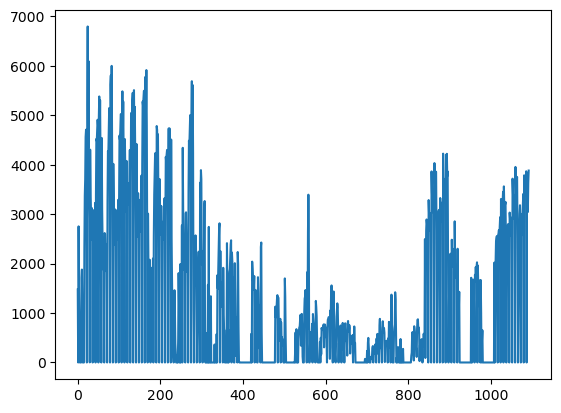

In [19]:
import matplotlib.pyplot as plt
plt.plot(preds)
plt.show()

In [20]:
submission.to_csv(os.path.join(sub_path,f"baseline_submission{sub_num}.csv"), index=False)

In [21]:
submission['answer'].isna().sum()

0